# Display of Buhman synapses - Neuroglancer links

This documnent contains code for:
<br>
<br>A) Take many segments IDs as one neuron and:
1. Display synaptic site in neuroglancer
2. Quantifying number of synaptic sites
3. Clustering synapses based on assumptions

<br>B) Displaying pre or postsynaptic sites between two segment IDs
<br>C) Linking pre and postsynaptic sites
<br>D) Displaying presynaptic sites of a given neuropile (try to mimicking Brp stainings)
<br>E) Visualizing neuron´s main branch location and cluster of neighboring neurons

## A) Many segments IDs as one neuron

### 1. Displaying synaptic sites in neuroglancer

In [1]:
import fafbseg
from fafbseg import flywire
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from nglui.statebuilder.helpers import make_synapse_neuroglancer_link
from helpers.synapse_queries import combine_xyz, separate_xyz, synapse_count
from caveclient import CAVEclient

client = CAVEclient('flywire_fafb_production')

C:\Users\smolina\Anaconda3\envs\EM\lib\site-packages\blessed\terminal.py:186: UserWarning: Failed to setupterm(kind='xterm-color'): Could not find terminal xterm-color
  warnings.warn(msg)


#### 1.1 Loading from URL:

In [14]:
#User's parameters
url = "https://ngl.flywire.ai/?json_url=https://globalv1.flywire-daf.com/nglstate/5614413943930880"
segments_dict = flywire.decode_url(url)
segmentsIDs = segments_dict["selected"]   # root ID query for a Dm4 segments

#### 1.1 Or, loading manually:

In [2]:
segmentsIDs = [720575940631226127,720575940633045933,720575940628912899,720575940631224079] # ids with no synapses when cleft score => 50
segmentsIDs = [720575940621983984] # Dm4 interesting case for Tm9: 720575940620703936
segmentsIDs = [720575940617527297] # L5 example

#### 1.1 Or, loading from excel file in PC:

In [ ]:
# Choose path and file
dataPath = r'C:\Users\sebas\Downloads'
fileName = 'Dm4 proofreading axon terminals_20221011.xlsx'
#fileName = 'Tm9 proofreadings.xlsx'
filePath = os.path.join(dataPath,fileName)

In [20]:
#Loading file as DataFrame
df = pd.read_excel(filePath)
if df["seg_id"][0] == 'asdf': #Dropping the fisrt row ('asdf' was added as a walk-around to set that column values as type str)
    df = df.iloc[1: , :]
    df.reset_index(inplace=True,drop=True)
display(df.head(1))
segmentsIDs = df["seg_id"]

,XYZ soma,XYZ,voxel_raw_x,voxel_raw_y,voxel_raw_z,symbol,hemisphere,lab,author,name,seg_id,twigs proofread (Y/N),identified_in,lab authorship (Y/N),notes,annotations_link,Extra notes (see comments),Working on
0,"61042, 90348, 5344","66139, 86342, 5433",66139.0,86342.0,5433.0,Tm9,R,Marion Silies,Jonas Chojetzki,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940629938298,Y,"Fischbach & Dittrich, 1989",Y,marked as complete and identified,https://ngl.flywire.ai/?json_url=https://globa...,NaN,NaN


#### 1.2 Updating IDs (necessary for correct annotations in neuroglancer and feching synapses with FAFBseg-py)

In [3]:
#Update IDs witth chunkedgraph module of CAVE
segmentsIDs_int = list(map(int,segmentsIDs))
new_segmentsIDs_int = list(map(client.chunkedgraph.get_latest_roots,segmentsIDs_int))


In [4]:
# Putting the new IDs into a list and getting a new neuroglancer URL
new_segmentsIDs_arr = np.concatenate(new_segmentsIDs_int, axis=0 )
new_segmentsIDs_ls = new_segmentsIDs_arr.tolist()
old_url = flywire.encode_url(segmentsIDs)
print(f'OLD segments: {old_url}')
new_url = flywire.encode_url(new_segmentsIDs_ls)
print(f'NEW segments: {new_url}')

OLD segments: https://ngl.flywire.ai/?json_url=https://globalv1.flywire-daf.com/nglstate/4761401086181376
NEW segments: https://ngl.flywire.ai/?json_url=https://globalv1.flywire-daf.com/nglstate/6737951063015424


#### 1.3 Generating the final URLs

In [5]:
# Important to fetch synapses from live materialization (mat = "live")
pre_synapses = flywire.synapses.fetch_synapses(new_segmentsIDs_ls, pre=True, post=False, attach=True,
                                          min_score=50, clean=True, transmitters=False,
                                          neuropils=True, batch_size=30,
                                          dataset='production', progress=True,mat="live")

#Combining x,y,z columns for future purposes
combine_xyz(pre_synapses)

url = make_synapse_neuroglancer_link(pre_synapses, client, point_column='pre_pt_position')
display(url)

In [6]:
# Important to fetch synapses from live materialization (mat = "auto")
post_synapses = flywire.synapses.fetch_synapses(new_segmentsIDs_ls, pre=False, post=True, attach=True, 
                                         min_score=50, clean=True, transmitters=False, 
                                         neuropils=True, batch_size=30,
                                         dataset='production', progress=True,mat="live")

#Combining x,y,z columns for future purposes
combine_xyz(post_synapses)

url = make_synapse_neuroglancer_link(post_synapses, client, point_column='post_pt_position')
display(url)

In [48]:
# Fetch the neuron's presynaptic sites (not using live materialization, danger of missing synapses)
pre_synapses = client.materialize.synapse_query(
        pre_ids = new_segmentsIDs_ls,
        bounding_box_column='pre_pt_position'
        )
pre_synapses = post_synapses[post_synapses['cleft_score'] >= 50]
#display(pre_synapses.head())
url = make_synapse_neuroglancer_link(pre_synapses, client, point_column='pre_pt_position')
display(url)

In [49]:
# Fetch the neuron's presynaptic sites (not using live materialization, danger of missing synapses)
post_synapses = client.materialize.synapse_query(
        post_ids = new_segmentsIDs_ls,
        bounding_box_column='post_pt_position'
        )
post_synapses = post_synapses[post_synapses['cleft_score'] >= 50]
#display(post_synapses.head())
url = make_synapse_neuroglancer_link(post_synapses, client, point_column='post_pt_position')
display(url)

### 2. Quantifying synaptic sites

### 2.1 Fecthing synapses

#### Using CAVE. No need of updating the segment IDs

In [33]:
#Probably we are using one of the materialization version below
client.materialize.get_versions()

[258, 526, 545, 547, 549, 447]

In [34]:
use_mat = 526

In [ ]:
pre_synapses = client.materialize.synapse_query(
        pre_ids = segmentsIDs,materialization_version = use_mat,
        )
print(f'Length without filter: {len(pre_synapses)}')
pre_synapses = pre_synapses[pre_synapses['cleft_score'] >= 50]
display(pre_synapses.head())
print(f'Length with filter: {len(pre_synapses)}')

In [35]:
post_synapses = client.materialize.synapse_query(
        post_ids = segmentsIDs,materialization_version = use_mat,
        )
print(f'Length without filter: {len(post_synapses)}')
post_synapses = post_synapses[post_synapses['cleft_score'] >= 50]
#display(post_synapses.head())
print(f'Length with filter: {len(post_synapses)}')

Length without filter: 635
Length with filter: 341


#### Using FAFBseq-py. Needs updated segment IDs (currently using live materializations)

In [36]:
# Fetching synapses (with  cleft score filter)
pre_synapses_updated = flywire.synapses.fetch_synapses(new_segmentsIDs_ls, pre=True, post=False, attach=True,
                                          min_score=50, clean=True, transmitters=False,
                                          neuropils=True, batch_size=30,
                                          dataset='production', progress=True,mat="live")

post_synapses_updated = flywire.synapses.fetch_synapses(new_segmentsIDs_ls, pre=False, post=True, attach=True, 
                                         min_score=50, clean=True, transmitters=False, 
                                         neuropils=True, batch_size=30,
                                         dataset='production', progress=True,mat="live")

print(f'Length with filter: {len(pre_synapses_updated)}')
print(f'Length with filter: {len(post_synapses_updated)}')

#Combining x,y,z columns for future purposes
combine_xyz(pre_synapses_updated) 
combine_xyz(post_synapses_updated)

Length with filter: 2123
Length with filter: 608


### 2.2 Counting synapses

#### 2.2.1 Using FAFBseq-py. Needs updated segment IDs (currently using live materializations)

In [ ]:
synapses_count_updated = fafbseg.flywire.synapses.synapse_counts(new_segmentsIDs_ls, by_neuropil=False, 
                                        min_score=50,mat='live', batch_size=10, dataset='production')

#### 2.2.1 Or, Using custom function (using any data frame)

In [ ]:
# Getting synapse_count data frame, among other interesting ones
count_pre, count_post, synapses_count_updated = synapse_count(pre_synapses_updated, post_synapses_updated)

#### Removing some repeated segments

In [ ]:
# Identifying those segments that have been merged with others
# (they will have more than one entry on the data frame)

duplicates_boolean = synapses_count_updated.duplicated(keep=False)
no_duplicates_boolean = [not elem for elem in duplicates_boolean] #flipping duplicates_boolean

duplicated_IDs = list(set(list(synapses_count_updated.index.values[duplicates_boolean])))
str_duplicated_IDs = list(map(str,duplicated_IDs))

#display(synapses_count_updated[no_duplicates_boolean])
#display(synapses_count_updated)

#### Saving the dataset for future plotting and analysis

In [ ]:
# Choose data frames to save

# Keeping the non duplicated IDs
count_pre_save =  count_pre[count_pre['presynaptic_ID'].isin(str_duplicated_IDs) == False].copy() 
count_post_save =  count_post[count_post['postsynaptic_ID'].isin(str_duplicated_IDs) == False].copy()
synapses_count_updated_save = synapses_count_updated[no_duplicates_boolean].copy()
synapses_count_updated_save.index = synapses_count_updated_save.index.map(str)


In [93]:
# Choose path and file
dataPath = r'C:\Users\sebas\Downloads'
fileName = 'Dm4_counts_axon_terminals.xlsx'
filePath = os.path.join(dataPath,fileName)

#To write in multiple sheets                                         
from openpyxl import load_workbook, Workbook

book = Workbook()
book.save(filename = filePath)
book = load_workbook(filePath)
writer = pd.ExcelWriter(filePath, engine = 'openpyxl')
writer.book = book

count_pre_save.to_excel(writer, sheet_name='count_pre')
count_post_save.to_excel(writer, sheet_name='count_post')
synapse_count_updated_save.to_excel(writer, sheet_name='synapse_count_total')

writer.save()
writer.close()

#### Some plotting to visualize variability

In [88]:
# Setting custmized seaborn style

#Black backgroung plots
sns.set(rc={'axes.facecolor':'k', 'figure.facecolor':'k','axes.grid' : False,'xtick.color': 'w',
     'ytick.color': 'w','axes.labelcolor': 'w','xtick.bottom': True})

In [86]:
# Setting custmized seaborn style

#White backgroung plots
sns.set(rc={'axes.facecolor':'w', 'figure.facecolor':'w','axes.grid' : False,'xtick.color': 'k',
     'ytick.color': 'k','axes.labelcolor': 'k','xtick.bottom': True})

In [48]:
# Boxplot for counts

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10, 3), facecolor='k', edgecolor='k')
sns.set(rc={'axes.facecolor':'k', 'figure.facecolor':'k','axes.grid' : False,'xtick.color': 'w',
     'ytick.color': 'w','axes.labelcolor': 'w','xtick.bottom': True})

#fig.suptitle('Predicted pre- and postsynaptic counts', fontsize=16)
ax[0].set_title('Presynaptic sites', color = 'w')
ax[1].set_title('Postsynaptic sites', color = 'w')

pre_plot = sns.boxplot(data =synapses_count_updated_save, x =synapses_count_updated_save['pre'],
            notch=False, showcaps=True,boxprops={"facecolor": (.4, .6, .8, .5)},
            medianprops={"color": "w"},flierprops={"marker": "x"}, ax=ax[0])
pre_plot = sns.swarmplot(data =synapses_count_updated_save, x =synapses_count_updated_save['pre'], 
                         color="w", ax=ax[0])

post_plot = sns.boxplot(data =synapses_count_updated_save, x =synapses_count_updated_save['post'],
            notch=False, showcaps=True,boxprops={"facecolor": (.4, .6, .8, .5)},
            medianprops={"color": "r"},flierprops={"marker": "x"}, ax=ax[1])
post_plot = sns.swarmplot(data =synapses_count_updated_save, x =synapses_count_updated_save['post'], 
                         color="r", ax=ax[1])

# This will add label to X-axis
pre_plot.set_xlabel("count")
post_plot.set_xlabel("count")



NameError: name 'synapses_count_updated_save' is not defined

In [82]:
# links to neuroglancer of the above counts
segmentsIDs= synapse_count_updated_save.index.tolist()

#Update IDs witth chunkedgraph module of CAVE
segmentsIDs_int = list(map(int,segmentsIDs))
new_segmentsIDs_int = list(map(client.chunkedgraph.get_latest_roots,segmentsIDs_int))

# Putting the new IDs into a list and getting a new neuroglancer URL
new_segmentsIDs_arr = np.concatenate(new_segmentsIDs_int, axis=0 )
new_segmentsIDs_ls = new_segmentsIDs_arr.tolist()
old_url = flywire.encode_url(segmentsIDs)
print(f'OLD segments: {old_url}')
new_url = flywire.encode_url(new_segmentsIDs_ls)
print(f'NEW segments: {new_url}')



OLD segments: https://ngl.flywire.ai/?json_url=https://globalv1.flywire-daf.com/nglstate/5733715888046080
NEW segments: https://ngl.flywire.ai/?json_url=https://globalv1.flywire-daf.com/nglstate/4567777792753664


In [23]:
# Important to fetch synapses from live materialization (mat = "live")
pre_synapses = flywire.synapses.fetch_synapses(new_segmentsIDs_ls, pre=True, post=False, attach=True,
                                          min_score=50, clean=True, transmitters=False,
                                          neuropils=True, batch_size=30,
                                          dataset='production', progress=True,mat="live")

#Combining x,y,z columns for future purposes
combine_xyz(pre_synapses)

url = make_synapse_neuroglancer_link(pre_synapses, client, point_column='pre_pt_position')
display(url)

Fetching synapses:   0%|          | 0/4 [00:00<?, ?it/s]

HTTPError: 413 Client Error: Request Entity Too Large for url: https://global.daf-apis.com/nglstate/api/v1/post content: b'<html>\r\n<head><title>413 Request Entity Too Large</title></head>\r\n<body>\r\n<center><h1>413 Request Entity Too Large</h1></center>\r\n<hr><center>nginx</center>\r\n</body>\r\n</html>\r\n'

In [49]:
# Important to fetch synapses from live materialization (mat = "auto")
post_synapses = flywire.synapses.fetch_synapses(new_segmentsIDs_ls, pre=False, post=True, attach=True, 
                                         min_score=50, clean=True, transmitters=False, 
                                         neuropils=True, batch_size=30,
                                         dataset='production', progress=True,mat="live")

#Combining x,y,z columns for future purposes
combine_xyz(post_synapses)

url = make_synapse_neuroglancer_link(post_synapses, client, point_column='post_pt_position')
display(url)

### -- Temporary pieces of code --

In [ ]:
# Fetch the neuron's inputs and ouputs
# Carefull, only fetching synapses among the provided IDs!!!
inputs = flywire.synapses.fetch_synapses(new_segmentsIDs_ls, pre=False, post=True, attach=True, 
                                         min_score=50, clean=True, transmitters=False, 
                                         neuropils=True, batch_size=30,
                                         dataset='production', progress=True)
outputs = flywire.synapses.fetch_synapses(new_segmentsIDs_ls, pre=True, post=False, attach=True,
                                          min_score=50, clean=True, transmitters=False,
                                          neuropils=True, batch_size=30,
                                          dataset='production', progress=True)

In [ ]:
# Making URLs for neuroglancer
combine_xyz(inputs) # corrects dataframe for make_synapse_neuroglancer_link
combine_xyz(outputs)# corrects dataframe for make_synapse_neuroglancer_link
inputs_url = make_synapse_neuroglancer_link(inputs, client, point_column='post_pt_position')
outputs_url = make_synapse_neuroglancer_link(outputs, client, point_column='pre_pt_position')
print('Inputs URL:')
display(inputs_url)
print('Outputs URL:')
display(outputs_url)

In [ ]:
# Separate x,y,z in diferent columns
separate_xyz(pre_synapses)
separate_xyz(post_synapses)

### 3. Clustering of  synaptic sites

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import colorcet as cc


In [27]:
# Choose data
data = np.array(pre_synapses['pre_pt_position'].tolist())

In [266]:
# CLustering of 3D data point
%matplotlib qt
#%matplotlib inline

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(data[:,0], data[:,1], data[:,2], s=40)
ax.view_init(azim=30,elev=50)
plt.show()


model = KMeans(n_clusters = 21, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)
model = DBSCAN(eps=400, min_samples=22)
#model.fit_predict(data)
pred = model.fit_predict(data)

fig = plt.figure()
ax = Axes3D(fig)
my_cmap = sns.color_palette("magma", as_cmap=True) 
ax.scatter(data[:,0], data[:,1], data[:,2], c=model.labels_*10, s=40,cmap=my_cmap)
ax.view_init(azim=30,elev=50)
plt.show()

print("number of clusters expected: {}".format(len(pre_synapses['pre_pt_root_id'].unique())))
print("number of clusters found: {}".format(len(set(model.labels_))))
print('cluster for each point: ', model.labels_)

number of clusters expected: 21
number of clusters found: 29
cluster for each point:  [ 0  0  3 ...  2 27 10]


C:\Users\sebas\anaconda3\envs\EM\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  
C:\Users\sebas\anaconda3\envs\EM\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


Text(0, 0.5, 'count')

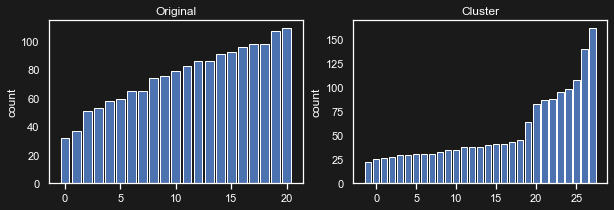

In [274]:
%matplotlib inline

segment_counts = np.array(synapse_count_updated_save['pre'].tolist())
labels, counts = np.unique(model.labels_,return_counts=True)


fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10, 3), facecolor='k', edgecolor='k')


#plt.hist(model.labels_, bins = 100)
ax[0].bar(list(range(0,len(segment_counts))),np.sort(segment_counts))
ax[1].bar(labels,np.sort(counts))

ax[0].set_title('Original', color = 'w')
ax[1].set_title('Clusters', color = 'w')

# This will add label to X-axis
ax[0].set_ylabel("count")
ax[1].set_ylabel("count")

array([ 86, 107,  59,  79,  58,  32,  53,  86,  82,  75,  96,  98, 109,
        65,  98,  92,  74,  37,  91,  51,  65])

<AxesSubplot:ylabel='count'>

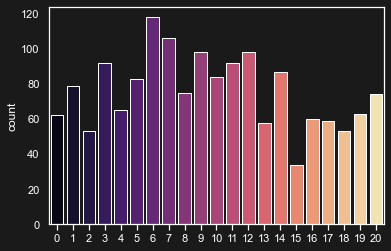

In [263]:
# Setting custmized seaborn style

#Black backgroung plots
sns.set(rc={'axes.facecolor':'k', 'figure.facecolor':'k','axes.grid' : False,'xtick.color': 'w',
     'ytick.color': 'w','axes.labelcolor': 'w','xtick.bottom': True})


sns.countplot(pred,  palette = "magma")

In [191]:
# Replotting individual clusters
cluster_idx = np.where(model.labels_ == 1)
#print(len(cluster_idx[0]))
cluster = data[cluster_idx]
#print(len(cluster))

%matplotlib qt
#%matplotlib inline
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(data[:,0], data[:,1], data[:,2], alpha =0.1,  s=20, color = "w") # ALl data
ax.scatter(cluster[:,0], cluster[:,1], cluster[:,2], alpha =1, s=40, color = "k") # Cluster data



ax.view_init(azim=30,elev=50)

plt.show()

C:\Users\sebas\anaconda3\envs\EM\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  # Remove the CWD from sys.path while we load stuff.


## B) Displaying pre or postsynaptic sites between two segment IDs

### 1. Input two segments IDs manually selected:

In [ ]:
import numpy as np
from caveclient import CAVEclient
from nglui.statebuilder.helpers import make_synapse_neuroglancer_link
from FANC_synaptic_links import to_ng_annotations, downscale

In [ ]:
client = CAVEclient('flywire_fafb_production')

In [ ]:
#Defaul values
top_left = np.array([65995, 84864, 5400])*[4,4,40]  # [65995, 84864, 5400], [158278, 71889, 2189]
bottom_right = np.array([69399, 86757, 5478])*[4,4,40]  # [69399, 86757, 5478], [171350, 73983, 2237]
defaul_pre_id = 720575940659388801 # L3
defaul_post_id = 720575940626482442 # Tm9


In [ ]:
synapses = client.materialize.synapse_query(
    bounding_box=[top_left, bottom_right],
    bounding_box_column='pre_pt_position')

# OR

synapses = client.materialize.synapse_query(
        pre_ids = int(defaul_pre_id), post_ids = int(defaul_post_id),
        bounding_box_column='pre_pt_position'
        )

In [ ]:
url = make_synapse_neuroglancer_link(synapses, client, point_column='pre_pt_position')

In [ ]:
display(url)

### 1. Or, load segment IDs from a google drive file (currently under development):

A quickstar to access Google Workspace API here: https://developers.google.com/sheets/api/quickstart/python#step_3_set_up_the_sample

In [ ]:
#Load file
#Option 1: currently not working

import pandas as pd
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow,Flow
from google.auth.transport.requests import Request
import os
import pickle

SCOPES = ['https://www.googleapis.com/auth/spreadsheets']
#GET https://sheets.googleapis.com/v4/spreadsheets/{spreadsheetId}/values/{range}

# here enter the id of your google sheet
SAMPLE_SPREADSHEET_ID_input = '1qpe8WBx07Tcza_-cLjYx1HLx1IMKoFjL'
SAMPLE_RANGE_NAME = 'A1:AA1000'

def main():
    global values_input, service
    creds = None
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                'credentials.json', SCOPES) # here enter the name of your downloaded JSON file
            creds = flow.run_local_server(port=0)
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)

    service = build('sheets', 'v4', credentials=creds)

    # Call the Sheets API
    sheet = service.spreadsheets()
    result_input = sheet.values().get(spreadsheetId=SAMPLE_SPREADSHEET_ID_input,
                                range=SAMPLE_RANGE_NAME).execute()
    values_input = result_input.get('values', [])

    if not values_input and not values_expansion:
        print('No data found.')

main()

df=pd.DataFrame(values_input)



In [ ]:
# Load file
#Option 2: currently not working
"""
BEFORE RUNNING:
---------------
1. If not already done, enable the Google Sheets API
   and check the quota for your project at
   https://console.developers.google.com/apis/api/sheets
2. Install the Python client library for Google APIs by running
   `pip install --upgrade google-api-python-client`
"""
from pprint import pprint

from googleapiclient import discovery
from google_auth_oauthlib.flow import InstalledAppFlow,Flow
from google.auth.transport.requests import Request
import os
import pickle

# TODO: Change placeholder below to generate authentication credentials. See
# https://developers.google.com/sheets/quickstart/python#step_3_set_up_the_sample
#
# Authorize using one of the following scopes:
#     'https://www.googleapis.com/auth/drive'
#     'https://www.googleapis.com/auth/drive.file'
#     'https://www.googleapis.com/auth/drive.readonly'
#     'https://www.googleapis.com/auth/spreadsheets'
#     'https://www.googleapis.com/auth/spreadsheets.readonly'

creds = None
if os.path.exists('token.pickle'):
    with open('token.pickle', 'rb') as token:
        creds = pickle.load(token)
if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file(
            'credentials.json', SCOPES) # here enter the name of your downloaded JSON file
        creds = flow.run_local_server(port=0)
    with open('token.pickle', 'wb') as token:
        pickle.dump(creds, token)

service = discovery.build('sheets', 'v4', credentials=creds)

# The ID of the spreadsheet to retrieve data from.
spreadsheet_id = '1qpe8WBx07Tcza_-cLjYx1HLx1IMKoFjL'  # TODO: Update placeholder value.

# The A1 notation of the values to retrieve.
range_ = 'A1:AA1000'  # TODO: Update placeholder value.

# How values should be represented in the output.
# The default render option is ValueRenderOption.FORMATTED_VALUE.
value_render_option = 'FORMATTED_VALUE'  # TODO: Update placeholder value.

# How dates, times, and durations should be represented in the output.
# This is ignored if value_render_option is
# FORMATTED_VALUE.
# The default dateTime render option is [DateTimeRenderOption.SERIAL_NUMBER].
date_time_render_option = 'SERIAL_NUMBER'  # TODO: Update placeholder value.

request = service.spreadsheets().values().get(spreadsheetId=spreadsheet_id, range=range_, valueRenderOption=value_render_option, dateTimeRenderOption=date_time_render_option)
response = request.execute()

# TODO: Change code below to process the `response` dict:
pprint(response)

### 1. Or, load segment IDs from an excel file:

In [8]:
# Choose path and file
import os

dataPath = r'C:\Users\sebas\Documents\connectomics-data\FlyWire\Excels'
fileName = 'All_Tm9_neurons_input_count_ME_R_20221206.xlsx'
filePath = os.path.join(dataPath,fileName)

In [9]:
#Loeading file as DataFrame
import pandas as pd

df = pd.read_excel(filePath)
if df["postsynaptic_ID"][0] == 'asdf': #Dropping the fisrt row ('asdf' was added as a walk-around to set that column values as type str)
    df = df.iloc[1: , :]
    df.reset_index(inplace=True,drop=True)
display(df.head())

,presynaptic_ID,Updated_pre_IDs (will replace the column on the left),counts,count %,postsynaptic_ID,"Comments about synapses proofreading (e.g., false negatíve found)","URL buhmann postsynapses (annotate only as: true, false or false negative)",Synapses proofread (Y/N),XYZ soma,XYZ,...,seg_id,twigs proofread (Y/N),FlyWire proofread (Y/N),identified_in,lab authorship (Y/N),notes,annotations_link,Extra notes as comments (initials),Working on,Unnamed: 28
0,720575940659388801,NaN,38.0,27.536232,720575940629938298,false negative found,https://ngl.flywire.ai/?json_url=https://globa...,Y,no soma,"61065, 87199, 4730",...,720575940659388801,Y,Y,"Fischbach & Dittrich, 1989",Y,NaN,https://ngl.flywire.ai/?json_url=https://globa...,done,NaN,NaN
1,720575940615238668,NaN,12.0,8.695652,720575940629938298,NaN,https://ngl.flywire.ai/?json_url=https://globa...,Y,"59355, 90055, 5482","66443, 86349, 5461",...,720575940615238668,N,Y,"Fischbach & Dittrich, 1989",Y,NaN,https://ngl.flywire.ai/?json_url=https://globa...,done,NaN,NaN
2,720575940613808815,NaN,8.0,5.797101,720575940629938298,NaN,https://ngl.flywire.ai/?json_url=https://globa...,y,"59642, 87973, 5337","61058, 86308, 5533",...,720575940613808815,N,Y,"Fischbach & Dittrich, 1989",Y,NaN,https://ngl.flywire.ai/?json_url=https://globa...,done,NaN,NaN
3,720575940625018512,NaN,5.0,3.623188,720575940629938298,NaN,https://ngl.flywire.ai/?json_url=https://globa...,Y,no soma,"60075, 85501, 4528",...,720575940625018512,Y,Y,"Fischbach & Dittrich, 1989",Y,projections in layer M2 and M4,https://ngl.flywire.ai/?json_url=https://globa...,done,NaN,NaN
4,720575940633484514,NaN,5.0,3.623188,720575940629938298,NaN,https://ngl.flywire.ai/?json_url=https://globa...,Y,NaN,"62895, 87995, 5152",...,720575940633484514,Y,N,"Fischbach & Dittrich, 1989",Y,NaN,https://ngl.flywire.ai/?json_url=https://globa...,"done, do not marked as complete. To difficult ...",NaN,NaN


In [5]:
#Generating a URL link with annotate synaptic connections for each "presynaptic_ID - postynaptic_ID" pair
# THis might take long time depending on the length of the DataFrame
import numpy as np
from caveclient import CAVEclient
from nglui.statebuilder.helpers import make_synapse_neuroglancer_link

client = CAVEclient('flywire_fafb_production')

# Filtering out the 'INPUTS PROOFREAD' row of the data frame
filtered_df = df[df["presynaptic_ID"] != 'INPUTS PROOFREAD'].copy()


### 2. Updating IDs

In [6]:
# Updating the IDs via Fafbseg (preferred)
pre_ID_ls = filtered_df ["presynaptic_ID"].tolist()
post_ID_ls = filtered_df ["postsynaptic_ID"].tolist()

updated_pre_ID_df = fafbseg.flywire.update_ids(pre_ID_ls, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)
updated_post_ID_df = fafbseg.flywire.update_ids(post_ID_ls, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)

new_pre_ID_ls = updated_pre_ID_df["new_id"].tolist()
new_post_ID_ls = updated_post_ID_df["new_id"].tolist()

Updating:   0%|          | 0/372 [00:00<?, ?it/s]

Updating:   0%|          | 0/372 [00:00<?, ?it/s]

In [25]:
# Updating the IDs via CAVE (not preferred)
pre_IDs_int = list(map(int,filtered_df ["presynaptic_ID"].tolist()))
post_IDs_int = list(map(int,filtered_df ["postsynaptic_ID"].tolist()))
new_pre_IDs_int = list(map(client.chunkedgraph.get_latest_roots,pre_IDs_int))
new_post_IDs_int = list(map(client.chunkedgraph.get_latest_roots,post_IDs_int))

#Required data type transformations
new_pre_IDs_arr = np.concatenate(new_pre_IDs_int, axis=0 )
new_pre_ID_ls = new_pre_IDs_arr.tolist()

new_post_IDs_arr = np.concatenate(new_post_IDs_int, axis=0 )
new_post_ID_ls = new_post_IDs_arr.tolist()


### 3. URL genereation

In [12]:
# Via Fafbseg (preferred)
url_list = []
for pre, post in zip(new_pre_ID_ls,new_post_ID_ls):
    if pre == 'INPUTS PROOFREAD': # skiping this row for now
        url_list.append('NEXT_PAIR')
        continue

    synapses = flywire.synapses.fetch_synapses(post,
                        pre=False, post=True, attach=True,
                        min_score=50, clean=True, transmitters=False,
                        neuropils=True, batch_size=30,
                        dataset='production', progress=True,mat="live")


    synapses = synapses[synapses['pre'] == pre]
    #Combining x,y,z columns for future purposes
    combine_xyz(synapses)
    # Getting URL
    url = make_synapse_neuroglancer_link(synapses, client,
            point_column='post_pt_position',return_as="url")
    url_list.append(url)

In [10]:
# Via CAVE (not preferred)
url_list = []
for pre, post in zip(new_pre_ID_ls,new_post_ID_ls):
    if pre == 'INPUTS PROOFREAD': # skiping this row for now
        url_list.append('NEXT_PAIR')
        continue
        
    synapses = client.materialize.synapse_query(
        pre_ids = pre, post_ids = post,
        bounding_box_column='post_pt_position'
        )
    url = make_synapse_neuroglancer_link(
        synapses, client,
        point_column='post_pt_position',
        link_pre_and_post=True, return_as="url"
        )
    url_list.append(url)

In [13]:
url_list

['https://ngl.flywire.ai/?json_url=https://global.daf-apis.com/nglstate/api/v1/5974395235336192',
 'https://ngl.flywire.ai/?json_url=https://global.daf-apis.com/nglstate/api/v1/5371996208627712',
 'https://ngl.flywire.ai/?json_url=https://global.daf-apis.com/nglstate/api/v1/5285324171247616',
 'https://ngl.flywire.ai/?json_url=https://global.daf-apis.com/nglstate/api/v1/5111177541582848',
 'https://ngl.flywire.ai/?json_url=https://global.daf-apis.com/nglstate/api/v1/5615941761105920',
 'https://ngl.flywire.ai/?json_url=https://global.daf-apis.com/nglstate/api/v1/4606656251953152',
 'https://ngl.flywire.ai/?json_url=https://global.daf-apis.com/nglstate/api/v1/5560400653320192',
 'https://ngl.flywire.ai/?json_url=https://global.daf-apis.com/nglstate/api/v1/6731042509553664',
 'https://ngl.flywire.ai/?json_url=https://global.daf-apis.com/nglstate/api/v1/6686300560162816',
 'https://ngl.flywire.ai/?json_url=https://global.daf-apis.com/nglstate/api/v1/5658949667782656',
 'https://ngl.flywir

### 4. Saving

In [14]:
# Adding the new url column to the data frame
filtered_df["URL buhmann postsynapses"] = url_list

# Writting in an existing excel file
from openpyxl import load_workbook
book = load_workbook(filePath)
writer = pd.ExcelWriter(filePath, engine = 'openpyxl')
writer.book = book

filtered_df.to_excel(writer, sheet_name='buhmann synapses')
writer.save()



## C) Linking pre and postsynaptic sites

You need to paste the dictionary into the neuroglancer annotation layer through the “Edit JSON state” button that you can access through the top-right corner menu.
Paste the dictionary to replace the [] after "annotations":
See the image below. Then press “Apply changes” and the synaptic links should show up.

<img src="./images_visualization/change_annotation_layer_neuroglancer.png"
     alt="Optic lobe"
     width="500" height="300" style="display: block; margin: 0 auto" />


In [ ]:
synapses_vectors = np.hstack(
        [np.vstack(synapses.pre_pt_position.values),
        np.vstack(synapses.post_pt_position.values)])

json_dict = to_ng_annotations(synapses_vectors, input_order='xyz', voxel_mip_center=1, input_units=(4,4,40))

## D) Displaying presynaptic sites of a given neuropile (try to mimicking Brp stainings)


### 1. Accesing data through filtered materializations (dumps by Sven Dorkenwald)


As far as I have checked, there is no way to select a group of Buhmann synapses with a non-rectangular volume, for example:<br><br>`top_left = np.array([158278, 71889, 2189])*[4,4,40]
bottom_right = np.array([171350, 73983, 2237])*[4,4,40]`
<br><br>`synapses = client.materialize.synapse_query(
    bounding_box=[top_left, bottom_right],
    bounding_box_column='pre_pt_position')`
<br><br>Thefore, to get all synapses for specific neuropils (not rectangular volumes), we work with dump tables shared by Sven Dorkenwald <a href="https://drive.google.com/drive/folders/1g7i3LMmDFcZXDXzevy3eUSrmcMJl2B6a">here.</a>
<br>Download the last dump first before continuing.

**DISCLAIMER:** Limited query to 200000 rows
<br><br>**TODO** : To get a CLEAN neuropil: 

1. Get all root_IDs (segment IDs) belonging to a given neuropile (loaded from dump materialization).
2. Pass these list in the `flywire.synapses.fetch_synapses` function to get XYZ location and the neuropile
3. Filter according to the neuropile

In [ ]:
# Choocing the latest dump files

import os
dataPath = r'D:\Sebastian\Science\FlyWire\materializations\487'
fileName = 'syn_proof_analysis_filtered_487.feather'
filePath = os.path.join(dataPath,fileName)

In [ ]:
import pyarrow.feather as feather

# Loading dumps
syn_df = feather.read_feather(filePath)

In [ ]:
# Getting all connecting pre and post IDs an specific neuropil

neuropile = 'ME_R' # Choosen neuropil
syn_threshold = [50,100] # minimum and maximum number of synapses to consider

print(f"Threshold: > {syn_threshold} synapses")
print("--")
syn_df = syn_df[((syn_df['syn_count'] > syn_threshold[0]) & (syn_df['syn_count'] < syn_threshold[1]))] # Sub dataframe for the selected threshold
print(f"Number of unique pre-IDs: {len(syn_df['pre_pt_root_id'].unique())}")
print(f"Number of unique post-IDs: {len(syn_df['post_pt_root_id'].unique())}")
print(f"Total number of synapses: {syn_df['syn_count'].sum()}")
print("--")

#Filtering for a neuropile and for more than one synaptic count
syn_neuropile_df = syn_df[(syn_df['neuropil'] == neuropile)] # Sub dataframe for the selected neuropile
print(f"Number of unique {neuropile} pre-IDs: {len(syn_neuropile_df['pre_pt_root_id'].unique())}")
print(f"Number of unique {neuropile} post-IDs: {len(syn_neuropile_df['post_pt_root_id'].unique())}")
print(f"Total number of {neuropile} synapses: {syn_neuropile_df['syn_count'].sum()}")

#Storing the IDs in a common list
pre_IDs = syn_neuropile_df['pre_pt_root_id'].unique().tolist()
post_IDs = syn_neuropile_df['post_pt_root_id'].unique().tolist()
segmentsIDs_ls = pre_IDs+post_IDs
segmentsIDs_ls = list(dict.fromkeys(segmentsIDs_ls))

In [ ]:
# Downsampling at the ID level
#(to avoid the limitation of queryng live materializations, as all CAVEclient or flywire functions do)

import random
random.seed(42)

group_of_items = segmentsIDs_ls
num_to_select = 5 
segmentsIDs_random_ls = random.sample(group_of_items, num_to_select)

In [ ]:
# Updating IDs
from fafbseg import flywire
df_upddated_segmentsIDs = flywire.update_ids(segmentsIDs_random_ls) 
new_segmentsIDs_ls = df_upddated_segmentsIDs.new_id.values

In [ ]:
# Getting synapses locations and neuropile
inputs = flywire.synapses.fetch_synapses(new_segmentsIDs_ls, pre=False, post=True, attach=True, 
                                         min_score=50, clean=True, transmitters=True, 
                                         neuropils=True, batch_size=30,
                                         dataset='production', progress=True)
outputs = flywire.synapses.fetch_synapses(new_segmentsIDs_ls, pre=True, post=False, attach=True,
                                          min_score=50, clean=True, transmitters=True,
                                          neuropils=True, batch_size=30,
                                          dataset='production', progress=True)


In [ ]:
# Getting the synapses location and generating URL (NOT CLEAN)
import caveclient
from nglui.statebuilder.helpers import make_synapse_neuroglancer_link

client = caveclient.CAVEclient("flywire_fafb_production")

pre_list = syn_neuropile_df ['pre_pt_root_id'].tolist()
post_list = syn_neuropile_df ['post_pt_root_id'].tolist()

synapses = client.materialize.synapse_query(
        pre_ids = pre_list, post_ids = post_list,
        bounding_box_column='pre_pt_position'
        )

url = make_synapse_neuroglancer_link(synapses, client, point_column='pre_pt_position')
display(url)

In [ ]:
# Getting neuropil-CLEAN synaptic locations
inputs_neuropil_df = inputs[inputs["neuropil"] == neuropile].copy() # Important here to get a copy and not just a slice
outputs_neuropil_df = outputs[outputs["neuropil"] == neuropile].copy()

In [ ]:
# Creating colums with combined XYZ positions for using the `make_synapse_neuroglancer_link` function
post_pt_position = []
for x,y,z in zip(inputs_neuropil_df['post_x'].tolist(),inputs_neuropil_df['post_y'].tolist(),inputs_neuropil_df['post_z'].tolist()):
    temp_ls = [x/4,y/4,z/40]
    post_pt_position.append(temp_ls)

pre_pt_position = []
for x,y,z in zip(outputs_neuropil_df['pre_x'].tolist(),outputs_neuropil_df['pre_y'].tolist(),outputs_neuropil_df['pre_z'].tolist()):
    temp_ls = [x/4,y/4,z/40]
    pre_pt_position.append(temp_ls)

In [ ]:
# Adding this new column to the dataset and changing some column names to use the `make_synapse_neuroglancer_link` function
#Adding
inputs_neuropil_df['post_pt_position'] = post_pt_position
outputs_neuropil_df['pre_pt_position'] = pre_pt_position
#Changing column names
inputs_neuropil_df.rename(columns={'pre': 'pre_pt_root_id', 'post': 'post_pt_root_id'}, inplace=True)
outputs_neuropil_df.rename(columns={'pre': 'pre_pt_root_id', 'post': 'post_pt_root_id'}, inplace=True)

In [ ]:
outputs_neuropil_df.head()

In [ ]:
# Downsampling at the final data frame level
#(to avoid the limitation of generating URL links with to many anotations)
downsampled_outputs_neuropil_df= outputs_neuropil_df.sample(n=30, random_state=42)

In [ ]:
# Generating URL (The connection is being aborted after some time if too many connections are included!)

import caveclient
from nglui.statebuilder.helpers import make_synapse_neuroglancer_link

client = caveclient.CAVEclient("flywire_fafb_production")

url = make_synapse_neuroglancer_link(downsampled_outputs_neuropil_df, client, point_column='pre_pt_position')
display(url)

### 1. Or,  accesing data without filters from the CAVE annotation system.. . 

**DISCLAIMER**: Currently it is not possible to get more than 200000 rows /data points from available tables.

Using low level access to the CAVE annotation system. More info, <a href= "https://natverse.org/fafbseg/reference/flywire_cave_client.html"> here</a> or <a href="https://caveclient.readthedocs.io/en/latest/guide/annotation.html?highlight=tables#getting-existing-tables"> here.</a>

In [ ]:
# Checking available tables

all_tables = client.annotation.get_tables()
#all_tables

In [ ]:
import caveclient
client = caveclient.CAVEclient("flywire_fafb_production")
ident_df = client.materialize.query_table("fly_synapses_neuropil") # identification dataframe  with neuropil data


In [ ]:
ident_df.head()

In [ ]:
from nglui.statebuilder.helpers import make_synapse_neuroglancer_link

url = make_synapse_neuroglancer_link(ident_df, client, point_column='pre_pt_position')

In [ ]:
display(url)

### 1. Or, getting a neuropile volume through itereations of rectangular boxes using "bounding_box" option from<br><br>`client.materialize.synapse_query`  (under development)

In [ ]:
# To be done

## E) Visualizing neuron´s main branch location and cluster of neighboring neurons

### 1. Load IDs from file

In [67]:
# Choose path and file
dataPath = r'C:\Users\sebas\Downloads'
fileName = 'Tm9 proofreadings_20221212.xlsx'
filePath = os.path.join(dataPath,fileName)

In [68]:
#Loading file as DataFrame
df = pd.read_excel(filePath)
if df["seg_id"][0] == 'asdf': #Dropping the fisrt row ('asdf' was added as a walk-around to set that column values as type str)
    df = df.iloc[1: , :]
    df.reset_index(inplace=True,drop=True)
display(df.head(1))

,XYZ soma,XYZ,voxel_raw_x,voxel_raw_y,voxel_raw_z,symbol,hemisphere,lab,author,name,seg_id,twigs proofread (Y/N),identified_in,lab authorship (Y/N),notes,annotations_link,Extra notes (see comments),Working on
0,"61042, 90348, 5344","66139, 86342, 5433",66139.0,86342.0,5433.0,Tm9,R,Marion Silies,Jonas Chojetzki,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940629938298,Y,"Fischbach & Dittrich, 1989",Y,marked as complete and identified,https://ngl.flywire.ai/?json_url=https://globa...,NaN,NaN


### 2. Applying som filters and changes to the data set

In [69]:
filtered_df = df[df['hemisphere']== 'R'].copy()
filtered_df = df.copy()

In [70]:
# transformig XYZ position from string to list of integers
XYZ = []
for s in filtered_df['XYZ'].tolist():
    s_ls = s.split(",")
    int_ls = list(map(int,s_ls))
    XYZ.append(int_ls )
    

### 3. Clustering 3D points

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import colorcet as cc

In [72]:
# Choose data
data = np.array(XYZ)

In [73]:
# CLustering of 3D data point
%matplotlib qt
#%matplotlib inline

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(data[:,0], data[:,1], data[:,2], s=40)
#ax.view_init(azim=30,elev=50)
plt.show()


model = KMeans(n_clusters = 21, init = "k-means++", max_iter = 300, n_init = 10, random_state = 0)
model = DBSCAN(eps=3200, min_samples=5)
#model.fit_predict(data)
pred = model.fit_predict(data)

fig = plt.figure()
ax = Axes3D(fig)
my_cmap = sns.color_palette("magma", as_cmap=True) 
ax.scatter(data[:,0], data[:,1], data[:,2], c=model.labels_*10, s=40,cmap=my_cmap)
#ax.view_init(azim=30,elev=50)
plt.show()

print("number of clusters found: {}".format(len(set(model.labels_))))
print('cluster for each point: ', model.labels_)

number of clusters found: 6
cluster for each point:  [ 0  0  1  1  1  2  2  2  0  0  0 -1 -1  0 -1  2 -1 -1  1  3  0 -1  3  2
  1 -1 -1  4  2 -1  4 -1 -1  0 -1 -1 -1 -1  2  0  3  3  2  3 -1  0  4  3
 -1 -1 -1  3  2  2 -1 -1  0  3 -1  3  4  3  3 -1  3 -1  0  0 -1 -1 -1 -1
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  0 -1
  4  4]


C:\Users\sebas\anaconda3\envs\EM\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  
C:\Users\sebas\anaconda3\envs\EM\lib\site-packages\ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


In [77]:
# Replotting individual clusters
cluster_idx = np.where(model.labels_ == 3)
#print(len(cluster_idx[0]))
cluster = data[cluster_idx]
#print(len(cluster))

%matplotlib qt
#%matplotlib inline
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(data[:,0], data[:,1], data[:,2], alpha =0.1,  s=20, color = "w") # ALl data
ax.scatter(cluster[:,0], cluster[:,1], cluster[:,2], alpha =1, s=40, color = "k") # Cluster data



ax.view_init(azim=30,elev=50)

plt.show()

C:\Users\sebas\anaconda3\envs\EM\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  # Remove the CWD from sys.path while we load stuff.


### 4. Update dataframe with cluster information

In [78]:
# Adding cluster IDs
filtered_df['cluster_id'] = list(model.labels_)

In [79]:
filtered_df

,XYZ soma,XYZ,voxel_raw_x,voxel_raw_y,voxel_raw_z,symbol,hemisphere,lab,author,name,seg_id,twigs proofread (Y/N),identified_in,lab authorship (Y/N),notes,annotations_link,Extra notes (see comments),Working on,cluster_id
0,"61042, 90348, 5344","66139, 86342, 5433",66139.0,86342.0,5433.0,Tm9,R,Marion Silies,Jonas Chojetzki,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940629938298,Y,"Fischbach & Dittrich, 1989",Y,marked as complete and identified,https://ngl.flywire.ai/?json_url=https://globa...,NaN,NaN,0
1,"60923, 89385, 5082","68466, 86246, 5321",68466.0,86246.0,5321.0,Tm9,R,Marion Silies,Jonas Chojetzki,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940620703936,Y,"Fischbach & Dittrich, 1989",Y,marked as complete and identified,https://ngl.flywire.ai/?json_url=https://globa...,NaN,NaN,0
2,"49895, 76393, 5276","59942, 73078, 5380",59942.0,73078.0,5380.0,Tm9,R,Marion Silies,Jonas Chojetzki,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940638891683,Y,"Fischbach & Dittrich, 1989",Y,marked as complete and identified,https://ngl.flywire.ai/?json_url=https://globa...,NaN,NaN,1
3,"48008, 75010, 5516","57862, 73661, 5554",57862.0,73661.0,5554.0,Tm9,R,Marion Silies,Annalena Oswald,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940613521635,Y,"Fischbach & Dittrich, 1989",Y,marked as complete and identified,https://ngl.flywire.ai/?json_url=https://globa...,NaN,NaN,1
4,"48464, 73609, 5485","57238, 72829, 5661",57238.0,72829.0,5661.0,Tm9,R,Marion Silies,Annalena Oswald,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940618719915,Y,"Fischbach & Dittrich, 1989",Y,marked as complete and identified,https://ngl.flywire.ai/?json_url=https://globa...,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,NaN,"72136, 68593, 3612",72136.0,68593.0,3612.0,Tm9,R,wernet_lab,emilkind,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940621284351,N,"Fischbach & Dittrich, 1989",Y,marked as complete and identified,NaN,NaN,NaN,4
94,"57329, 87166, 5546","63165, 83785, 5499",63165.0,83785.0,5499.0,Tm9,R,Marion Silies,Sebastian Molina-Obando,"Tm9, Tm9_R, transmedullary neuron Tm9, FBbt_00...",720575940604173489,N,"Fischbach & Dittrich, 1989",Y,marked as complete and identified,NaN,NaN,NaN,0
95,"76238, 48102, 3553","77991, 52552, 3887",77991.0,52552.0,3887.0,Tm9 ???,R,"Mala Murthy Lab, Sebastian Seung Lab",J. Dolorosa,NaN,720575940622340009,N,"Fischbach & Dittrich, 1989",NaN,marked as complete,https://ngl.flywire.ai/?json_url=https://globa...,NaN,NaN,-1
96,"66049, 64574, 3210","62414, 66822, 4216",62414.0,66822.0,4216.0,Tm9 ???,R,"Mala Murthy Lab, Sebastian Seung Lab",Ariel Dagohoy,NaN,720575940636624356,N,"Fischbach & Dittrich, 1989",NaN,marked as complete,https://ngl.flywire.ai/?json_url=https://globa...,NaN,NaN,4


### 5. Saviing back in the excel file

In [80]:
#To write in multiple sheets                                         
from openpyxl import load_workbook, Workbook

book = Workbook()
book.save(filename = filePath)
book = load_workbook(filePath)
writer = pd.ExcelWriter(filePath, engine = 'openpyxl')
writer.book = book

filtered_df.to_excel(writer, sheet_name='cluster_ids')

writer.save()
writer.close()